In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data-new-128/x_second_batch.npz
/kaggle/input/data-new-128/y_valid_first_batch.npz
/kaggle/input/data-new-128/x_valid_first_batch.npz
/kaggle/input/data-new-128/y_valid_second_batch.npz
/kaggle/input/data-new-128/x_valid_second_batch.npz
/kaggle/input/data-new-128/x_first_batch.npz
/kaggle/input/data-new-128/y_test.npz
/kaggle/input/data-new-128/y_second_batch.npz
/kaggle/input/data-new-128/x_test.npz
/kaggle/input/data-new-128/y_first_batch.npz
/kaggle/input/bladder-licenta/MRIDoarPerete/corpodean/Segmentation.nrrd
/kaggle/input/bladder-licenta/MRIDoarPerete/dragan/Segmentation.nrrd
/kaggle/input/bladder-licenta/MRIDoarPerete/farago/Segmentation.nrrd
/kaggle/input/bladder-licenta/MRIDoarPerete/iles/Segmentation.nrrd
/kaggle/input/bladder-licenta/MRIDoarPerete/albu ok/Segmentation.nrrd
/kaggle/input/bladder-licenta/MRIDoarPerete/ciucur/Segmentation.nrrd
/kaggle/input/bladder-licenta/MRIDoarPerete/balogh/Segmentation.nrrd
/kaggle/input/bladder-licenta/MRIDoarPerete/matyas/

In [2]:
!pip install tensorflow==2.4.1
!pip install keras==2.4.3

In [3]:
!pip install pynrrd
!pip install pydicom
# !pip install -U tensorboard

In [4]:
%matplotlib inline

# Importing libraries needed for data processing

import os
import numpy as np
import nrrd
import pandas as pd
import random
import tensorflow as tf

# Adding a path

from pathlib import Path


# Necessary libraries for image alteration and animations

from ipywidgets import interact, interactive, IntSlider, ToggleButtons
from scipy import ndimage
from skimage import measure
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import pydicom as dicom

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import cv2
from sklearn.cluster import KMeans
import scipy


# Keras

import os
import skimage.io as io
import skimage.transform as trans
# import tensorflow.contrib.keras as keras
# from tensorflow.keras.models import Model


2022-05-20 16:35:08.998594: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [5]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler,EarlyStopping , ReduceLROnPlateau
from tensorflow.keras import backend as keras
from tensorflow.keras import utils
from functools import partial
from tensorflow.keras import backend as K

# Importing needed libraries for constructing 3DUnet


from tensorflow.keras.layers import Input, LeakyReLU, Add, UpSampling3D, Activation, SpatialDropout3D, Conv3D,Conv3DTranspose,PReLU,Softmax,ReLU,Concatenate 
from keras.engine import Model
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import concatenate

from keras.losses import categorical_crossentropy,mse

# K.set_image_data_format("channels_first")
K.set_image_data_format("channels_last")

# Time

from tqdm.notebook import tqdm
import time
import datetime

# Visualization

import tensorboard

# Loading in the data

In [6]:
def load_data():
    """
    Loading the data. We will only load in 9 patients because we will test the algorithm on the 10th one
    """
 
    patients=[]
    labels_perete=[]
    labels_tumoare=[]
    
    pacients_names=['albu ok','balogh','ciucur','cocan','corpodean','dragan','farago','iles','matyas','BUDISAN','dancila','fane','gyurka','jecan','magirescu','marc','maternik','pop','vadean']
    
    
    for i in range(len(pacients_names)):
        
        path1='../input/date-vezica/Date Vezica/Original/'
        path2='../input/date-vezica/Date Vezica/Perete/'
        path3='../input/date-vezica/Date Vezica/Tumoare/'
        patient, _= nrrd.read(path1+pacients_names[i]+'/' +os.listdir(path1+pacients_names[i])[0])
        label_perete, _= nrrd.read(path2+pacients_names[i]+'/' +os.listdir(path2+pacients_names[i])[0])
        label_tumoare, _= nrrd.read(path3+pacients_names[i]+'/' +os.listdir(path3+pacients_names[i])[0])
        patients.append(patient)
        labels_perete.append(label_perete)
        labels_tumoare.append(label_tumoare)
        

    return patients,labels_perete,labels_tumoare



In [7]:
patients,labels_perete,labels_tumori=load_data()

In [8]:
path1='../input/pacurar-new/4 Ax T2 PROP 3mm.nrrd'
path2='../input/pacurar-new/Segmentation.seg.nrrd'
patient, _= nrrd.read(path1)
label, _= nrrd.read(path2)

In [9]:
print(' We have ' + str(len(patients))+ ' in total')
print('   Patients    '+'|'+'     Wall       '+'|'+'    Tumor')
print('--------------------------------------------')

for i in range(len(patients)):
    print(str(patients[i].shape)+' |'+ str(labels_perete[i].shape) +' |'+str(labels_tumori[i].shape))        

 We have 19 in total
   Patients    |     Wall       |    Tumor
--------------------------------------------
(512, 512, 41) |(512, 512, 41) |(512, 512, 41)
(512, 512, 50) |(512, 512, 50) |(512, 512, 50)
(512, 512, 50) |(512, 512, 50) |(512, 512, 50)
(512, 512, 50) |(512, 512, 50) |(512, 512, 50)
(512, 512, 47) |(512, 512, 47) |(512, 512, 47)
(512, 512, 48) |(512, 512, 48) |(512, 512, 48)
(512, 512, 50) |(512, 512, 50) |(512, 512, 50)
(512, 512, 50) |(512, 512, 50) |(512, 512, 50)
(512, 512, 38) |(512, 512, 38) |(512, 512, 38)
(512, 512, 40) |(512, 512, 40) |(512, 512, 40)
(512, 512, 37) |(512, 512, 37) |(512, 512, 37)
(512, 512, 33) |(512, 512, 33) |(512, 512, 33)
(512, 512, 42) |(512, 512, 42) |(512, 512, 42)
(512, 512, 50) |(512, 512, 50) |(512, 512, 50)
(512, 512, 48) |(512, 512, 48) |(512, 512, 48)
(512, 512, 46) |(512, 512, 46) |(512, 512, 46)
(512, 512, 38) |(512, 512, 38) |(512, 512, 38)
(512, 512, 50) |(512, 512, 50) |(512, 512, 50)
(512, 512, 50) |(512, 512, 50) |(512, 512, 50

In [10]:
def show_patient(x,nr,patient,labels_p,labels_t):
    fig, ax = plt.subplots(1,3,figsize=[12, 12])
    img_1 = patient[nr][:,:,x]
    img_2 = labels_p[nr][:,:,x]
    img_3 = labels_t[nr][:,:,x]
    rotated_img_1 = ndimage.rotate(img_1, 270)
    rotated_img_2 = ndimage.rotate(img_2, 270)
    rotated_img_3 = ndimage.rotate(img_3, 270)
    ax[0].imshow(rotated_img_1,cmap='gray')
    ax[0].axis('off')
    ax[0].set_title(" Original ")
    ax[1].set_title("Perete")
    ax[1].imshow(rotated_img_2,cmap='gray')
    ax[1].axis('off')
                                   
    ax[2].set_title("Tumoare")              
    ax[2].imshow(rotated_img_3,cmap='gray')
    ax[2].axis('off')
    plt.show()


In [11]:
patient_test = patients[1]

In [12]:
def min_max(parent_size):
    x_max = np.amax(parent_size, axis=(0, 1, 2))
    x_min = np.amin(parent_size, axis=(0, 1, 2))
    
    x = (parent_size- x_min)/(x_max - x_min)
    x[x<0.5] = 0
    x[x>0.5] = 1
    return x

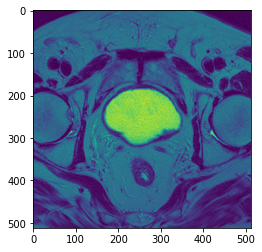

In [13]:
plt.imshow(ndimage.rotate(np.array(patient_test)[:,:,30],270))

In [14]:
# Showing the nrrd file and the segmentations for three random patients
three_patients = np.random.choice(len(patients),3,replace=False)

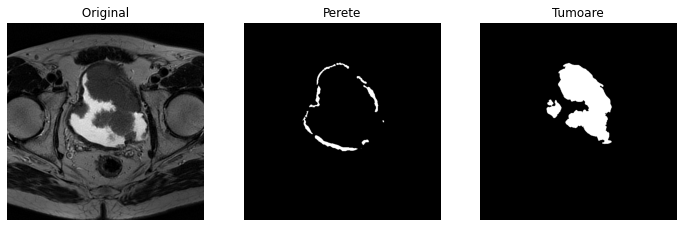

In [15]:
show_patient(25,three_patients[0],patients,labels_perete,labels_tumori)

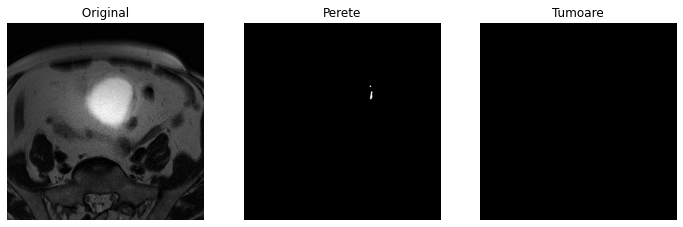

In [16]:
show_patient(31,three_patients[1],patients,labels_perete,labels_tumori)

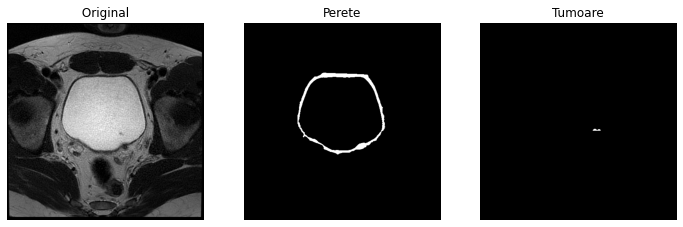

In [17]:
show_patient(22,three_patients[2],patients,labels_perete,labels_tumori)

In [18]:
def split(X, Y1, Y2, nr, sample=None):
    """
    :param X:(list of 3D Numpy Arrays) lista cu datele pacientilor
    :param Y:(list of 3D Numpy Arrays) lista cu masti(tumoare+perete) pacientilor
    :returns: Mostre impartite in : data pentru antrenare, si data pentru testare
    """
    indexes=[i for i in range(len(X))]
    if sample is None:
        sample=np.random.choice(indexes,nr,replace=False)
    print("Date alese pentru antrenat")
    print(sample)
    x_train_1 = [X[sample[i]] for i in range(len(sample)) if i<7]
    x_train_2 = [X[sample[i]] for i in range(len(sample)) if i>=7]
    x_test = [X[i] for i in indexes if i not in sample]
    
    print("Pentru primul batch")
    s1 = [sample[i] for i in range(len(sample)) if i<7]
    print(s1)
    print("Al doilea batch")
    s2 = [sample[i] for i in range(len(sample)) if i>=7]
    print(s2)
    
    d_sample = [i for i in indexes if i not in sample]
    print("Date alese pentru testat")
    print(d_sample)
    
    y_train_tum_1 = [Y1[sample[i]] for i in range(len(sample)) if i<7]
    y_train_wall_1 = [Y2[sample[i]] for i in range(len(sample)) if i<7]
    y_train_tum_2 = [Y1[sample[i]] for i in range(len(sample)) if i>=7]
    y_train_wall_2 = [Y2[sample[i]] for i in range(len(sample)) if i>=7]
    y_test_tum = [Y1[i] for i in indexes if i not in sample]
    y_test_wall = [Y2[i] for i in indexes if i not in sample]
    
    return x_train_1, x_train_2, x_test, y_train_tum_1, y_train_wall_1, y_train_tum_2, y_train_wall_2, y_test_tum, y_test_wall

In [19]:
patients_1, patients_2, patients_test, labels_tum_1, labels_wall_1, labels_tum_2, labels_wall_2, labels_tum_test, labels_wall_test = split(patients,labels_tumori,labels_perete,14,[12, 6, 3, 5, 14, 13, 2, 1, 16, 10, 7, 17, 0, 4])

Date alese pentru antrenat
[12, 6, 3, 5, 14, 13, 2, 1, 16, 10, 7, 17, 0, 4]
Pentru primul batch
[12, 6, 3, 5, 14, 13, 2]
Al doilea batch
[1, 16, 10, 7, 17, 0, 4]
Date alese pentru testat
[8, 9, 11, 15, 18]


In [20]:
# Date alese pentru antrenat
# [12  6  3  5 14 13  2  1 16 10  7 17  0  4]
# Pentru primul batch
# [12, 6, 3, 5, 14, 13, 2]
# Al doilea batch
# [1, 16, 10, 7, 17, 0, 4]
# Date alese pentru testat
# [8, 9, 11, 15, 18]

In [21]:
# plt.imshow(ndimage.rotate(patients[0][:,:,20], 270)patients[0][:,:,20])

# EXTRACTING THE ROI
AS PUTEA SA AUTOMATIZEZ ASTA PRIN MIN MAX NORMALISATION SI UN THRESHOLD DE 0.5

In [22]:
def combine_labels(labels_perete,labels_tumori):
    """
    Auxiliary function that helps us combine the labels for extracting the ROI
    :param labels_perete:(list of 3D numpy arrays) list of wall masks
    :param labels_tumori:(list of 3D numpy arrays) list of tumor masks
    
    :returns:
    labels: A list which has, for every 2D map:
    -1 if there is a wall or tumor present in the array
    -0 otherwise
    
    """
    for i in range(len(labels_perete)):
        x=labels_perete[i]
        labels_perete[i]=np.where(x!=0, 255, x)

    for i in range(len(labels_tumori)):
        x=labels_tumori[i]
        labels_tumori[i]=np.where(x!=0, 125, x)

    labels=[]
    
    for i in range(len(labels_perete)):
        labels.append(labels_tumori[i]+labels_perete[i])

    for i in range(len(labels)):
        x=labels[i]
        labels[i]=np.where(x!=0 ,1, x)
        
        
    return labels

In [23]:
# List of labels that we will take into account when extracting the ROI
labels_1 = combine_labels(labels_wall_1, labels_tum_1)
labels_2 = combine_labels(labels_wall_2, labels_tum_2)
labels_test = combine_labels(labels_wall_test, labels_tum_test)

In [24]:
len(labels_wall_2)

7

In [25]:
patient_1 = patients_1[0]
patient_2 = patients_2[0]
patient_test = patients_test[0]

In [26]:
def take_sub_volumes(image_data,label_data,labels_perete,labels_tumoare,sub_x=300,sub_y=300,sub_z=32,max_tries=200,threshold=0.95):
    """
    Takes the ROI manually based on the placement of the wall and tumor
    
    :param image_data:(3D Numpy Array) lista cu data pacientului
    :param label_data:(3D Numpy Array) - label-ul obtinut din combinarea labels_perete si labels_tumoare
    :param labels_perete:(3D Numpy Array) - mastile de perete pentru pacient
    :param labels_tumoare:(3D Numpy Array) - mastile de tumoare pentru pacient
    :param sub_x:(int) dimensiunea x a sub-volumului dorit
    :param sub_y:(int) - dimensiunea y a sub-volumului dorit
    :param sub_z:(int) - dimensiunea z a sub-volumului dorit
    :param max_tries:(int) - de cate ori incearca algoritmul sa gaseasca un sub-volum
    
    :returns:
    X: un sub-volum a imaginii originale
    Y: un sub-volum al mastii combinate asociate imaginii originale
    
    """
    p_bar = tqdm(range(max_tries))
    X=None
    Y=None
    forbidden=[]
    reset=0
    if image_data.shape[0]<label_data.shape[0]:
         main_x=image_data.shape[0]
    else:
         main_x=label_data.shape[0]

    if image_data.shape[1]<label_data.shape[1]:
         main_y=image_data.shape[1]
    else:
         main_y=label_data.shape[1]

    if image_data.shape[2]<label_data.shape[2]:
         main_z=image_data.shape[2]
    else:
         main_z=label_data.shape[2]
    
    best_backgr_ratio=0.99
    neighbour_tries=0
     
    best_x=0
    best_y=0
    best_z=0
    
    for tries in p_bar:
        
        p_bar.set_description(f'Working on "{tries+1}"')
        if main_x==sub_x:
            x=0
        else:
            x=np.random.randint(50,150)
    
        if main_y==sub_y:
            y=0
        else:
            y=np.random.randint(50,150)
            
        if main_z==sub_z:
            z=0
        elif main_z-sub_z+1>5:
            z=np.random.randint(5,main_z-sub_z+1)
        else:
            z=0
        
        sub_volume=label_data[x:x+sub_x,y:y+sub_y,z:z+sub_z]
        
        for volume in forbidden:
            if (sub_volume.shape[0]==volume.shape[0] and sub_volume.shape[1]==volume.shape[1] and sub_volume.shape[2]==volume.shape[2]):
                if ((sub_volume==volume).all()):
                    reset=1
                    if tries==max_tries-1:
                        reset=0
                        print(tries)
                    forbidden.append(sub_volume)
                    break
                
        if (reset==1):
            reset=0
            time.sleep(0.001)
            continue   #repetam while deoarece volumul nu este bun
        
        
        # Calculam raportul de fundal
        background_ratio= np.count_nonzero(label_data[x:x+sub_x,y:y+sub_y,z:z+sub_z]==0) / ((sub_x*sub_y*sub_z)+(1e-7))
        
    
        if background_ratio>0.99 and tries!=max_tries-1:
            forbidden.append(sub_volume)
            time.sleep(0.001)
            continue

        
        if background_ratio<best_backgr_ratio:
            best_backgr_ratio=background_ratio
            best_x=x
            best_y=y
            best_z=z
      
        if tries==max_tries-1:
            
            Y_perete=labels_perete[best_x:best_x+sub_x,best_y:best_y+sub_y,best_z:best_z+sub_z]
            Y_tumoare=labels_tumoare[best_x:best_x+sub_x,best_y:best_y+sub_y,best_z:best_z+sub_z]
            X=np.copy(image_data[best_x:best_x+sub_x,best_y:best_y+sub_y,best_z:best_z+sub_z]) 
           
            return X,Y_perete,Y_tumoare
        
        time.sleep(0.001)


def resize_volume_take_sub_volume(volume_list,label_list,labels_perete,labels_tumori):
    """
    Resizes the array of 3D Numpy Arrays
    :param volume_list:(Numpy array de 3D Numpy arrays)
    :param label_list:(Numpy array de 3D Numpy arrays) 
    :param labels_perete:(Numpy array de 3D Numpy arrays) 
    :param labels_tumori:(Numpy array de 3D Numpy arrays) 
    :returns:
    :volume_list: The array with the elements resized
    :labels_perete: The array with the bladder wall masks of resized elements
    :labels_tumori: The array with the tumor masks of resized elements
      """
    
    for i in range(len(volume_list)):
        volume_list[i],labels_perete[i],labels_tumori[i]=take_sub_volumes(volume_list[i],label_list[i],labels_perete[i],labels_tumori[i])

    return volume_list,labels_perete,labels_tumori

In [27]:
patients_1 ,labels_wall_1, labels_tum_1 = resize_volume_take_sub_volume(patients_1 ,labels_1, labels_wall_1, labels_tum_1)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [28]:
patients_2 ,labels_wall_2, labels_tum_2 = resize_volume_take_sub_volume(patients_2 ,labels_2, labels_wall_2, labels_tum_2)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [29]:
patients_test ,labels_wall_test, labels_tum_test = resize_volume_take_sub_volume(patients_test ,labels_test, labels_wall_test, labels_tum_test)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [30]:
# Preprocessing the labels so that for bladder wall the value is 255 and for the tumor 125

def change_values(labels_p, labels_t):
    for i in range(len(labels_p)):
        x=labels_p[i]
        labels_p[i]=np.where(x==255, 1, x)

    for i in range(len(labels_t)):
        x=labels_t[i]
        labels_t[i]=np.where(x==125, 1, x)
    
    return labels_p, labels_t

In [31]:
labels_wall_1, labels_tum_1 = change_values(labels_wall_1, labels_tum_1)

In [32]:
labels_wall_2, labels_tum_2 = change_values(labels_wall_2, labels_tum_2)

In [33]:
labels_wall_test, labels_tum_test = change_values(labels_wall_test, labels_tum_test)

In [34]:
def show_subvolume(patient,patients,x,y,nr):
    fig, ax = plt.subplots(1,2, figsize=[12, 12])
    img_pt = patient[:,:,x]
    img_org = patients[nr][:,:,y]
    rotated_img = ndimage.rotate(img_pt, 270)
    rotated_img_lb = ndimage.rotate(img_org, 270)
#     ax[0].set_title("Segmentation Class 2")
    ax[0].imshow(rotated_img,cmap='gray')
    ax[0].axis('off')
#     ax[1].set_title(" Original ")
    ax[1].imshow(rotated_img_lb,cmap='gray')
    ax[1].axis('off')
    plt.show()


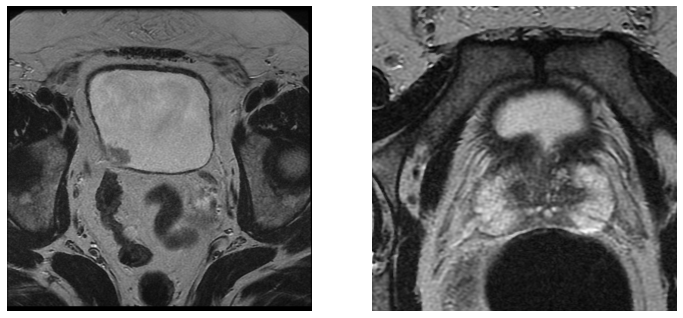

In [35]:
show_subvolume(patient_1,patients_1,30,13,0)

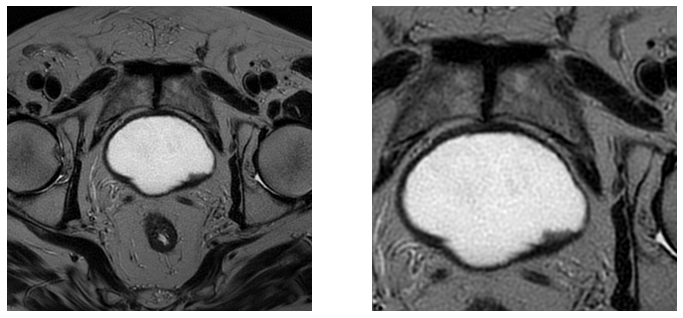

In [36]:
show_subvolume(patient_2,patients_2,30,19,0)

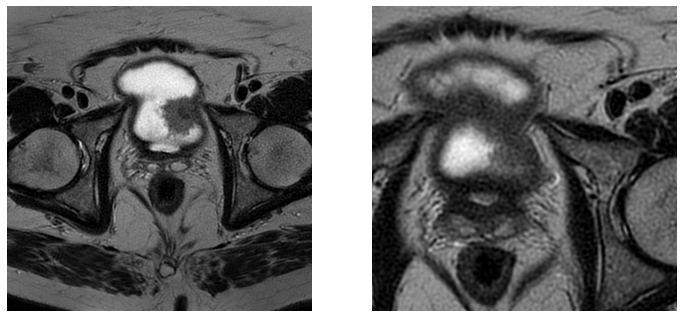

In [37]:
show_subvolume(patient_test,patients_test,20,13,0)

# Augmenting the data
* Marim data prin adaugarea datelor modificate prin rotire si/sau rasturnare
* Folosindu-ne de libraria scimpy putem roti orice imagine cu un anumit unghi dar ea schimba valoarea pixelilor deci nu o vom putea aplica singura pe masti  de aici aparand nevoia de a adauga un pas pentru masti
* Vom aplica mastilor functia to_categorical pentru a putea distinge intre tumoare/perete si fundal deoarece functia distinge perfect locul care ne intereseaza de fundal

In [38]:
def image_rotate3D_given_angle(img_numpy, angle):
    """
    Rotates a 3D Numpy array with the given angle
    :param img_numpy: 3D numpy array
    :param min_angle:(int) angle in grades
    :param max_angle:(int) angle in grades
    :returns: 2 3D Numpy arrays
    
    """
    assert img_numpy.ndim == 3, "The array needs to be 3D"
    assert angle > -360 or angle < 360 ,"The angle needs to be between -360 and 360"
    
    return scipy.ndimage.rotate(img_numpy, angle,order=1,mode='constant')


def flip(data):
    """
    Horizontali flip a 3D Numpy array
    :param data: 3D numpy array
    :param label: 3D numpy array
    :returns: 3D Numpy arrays rasturnat 
    """
    axis=0
    volume=data
    
    volume = np.asarray(volume).swapaxes(axis, 0)
    volume = volume[::-1, ...]
    volume = volume.swapaxes(0, axis)
    volume = np.squeeze(volume)

    return volume


# Function used for mask alteration

def masks_rotated3D_given_angle(mask_volume,angle):
    """
    Functie individuala pentru rotirea mastilor
    :param mask_volume: 3D Numpy array a mastii
    :param angle:(int) unghiul dupa care sa fie rotit
    """
    mask_r=image_rotate3D_given_angle(mask_volume,angle)
    mask_r=utils.to_categorical(mask_r,0)
    mask_r=mask_r[:,:,:,1]

    return mask_r

In [39]:
def elastic_transform(image,label_p,label_t, alpha, sigma, alpha_affine, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_ (with modifications).
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
         Convolutional Neural Networks applied to Visual Document Analysis", in
         Proc. of the International Conference on Document Analysis and
         Recognition, 2003.

     Based on https://gist.github.com/erniejunior/601cdf56d2b424757de5
    """
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    shape_size = shape[:2]
    
    # Random affine
    center_square = np.float32(shape_size) // 2
    square_size = min(shape_size) // 3
    pts1 = np.float32([center_square + square_size, [center_square[0]+square_size, center_square[1]-square_size], center_square - square_size])
    pts2 = pts1 + random_state.uniform(-alpha_affine, alpha_affine, size=pts1.shape).astype(np.float32)
    M = cv2.getAffineTransform(pts1, pts2)
    image = cv2.warpAffine(image, M, shape_size[::-1], borderMode=cv2.BORDER_REFLECT_101)
    image_2 = cv2.warpAffine(label_p, M, shape_size[::-1], borderMode=cv2.BORDER_REFLECT_101)
    image_3 = cv2.warpAffine(label_t, M, shape_size[::-1], borderMode=cv2.BORDER_REFLECT_101)
    
    blur_size = int(4 * sigma) | 1
    dx = cv2.GaussianBlur(
        (random_state.rand(*shape) * 2 - 1).astype(np.float32),
        ksize=(blur_size, blur_size), sigmaX=sigma) * alpha
    dy = cv2.GaussianBlur(
        (random_state.rand(*shape) * 2 - 1).astype(np.float32),
        ksize=(blur_size, blur_size), sigmaX=sigma) * alpha
    dz = np.zeros_like(dx)

    x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1)), np.reshape(z, (-1, 1))

    return (ndimage.map_coordinates(image, indices, order=1, mode='reflect').reshape(shape),
ndimage.map_coordinates(image_2, indices, order=1, mode='reflect').reshape(shape),
ndimage.map_coordinates(image_3, indices, order=1, mode='reflect').reshape(shape))

In [40]:
def Augment_patient(patient,patient_mask_perete,patient_mask_tumoare):
    """
    Augments the data:
    For every patients it adds 8 transformed images to our list of pacients,
    and their respective transformed masks to our list of masks
    
    :param healthy_patient:(3D Numpy Array) Pacient that will be transformed
    :param healthy_patient_mask:(3D Numpy Array) Their masks
    """
    X=[patient]
    Y_perete=[patient_mask_perete]
    Y_tumoare=[patient_mask_tumoare]
#     If validation data is needed, uncomment all of these below
    X_validare=[]
    Y_validare_p=[]
    Y_validare_t=[]
    all_angles_neg=[-15,-14,-13,-12,-11,10,-9,-8]
    all_angles_pos=[15,14,13,12,11,10,9,8]
    
    positions_pos=np.random.choice(all_angles_pos,size=3)
    positions_neg=np.random.choice(all_angles_neg,size=3)
    positions=[]

    for i in range(1):
        positions.append(positions_pos[i])
        
    for i in range(1):
        positions.append(positions_neg[i])


    for i in range(0,2):
        # Roteste volumul cu unghiul dat
        arr_new_patient=image_rotate3D_given_angle(patient,positions[i])
        arn_new_label_parete=masks_rotated3D_given_angle(patient_mask_perete,positions[i])
        arn_new_label_tumoare=masks_rotated3D_given_angle(patient_mask_tumoare,positions[i])
        X.append(arr_new_patient)
        Y_perete.append(arn_new_label_parete)
        Y_tumoare.append(arn_new_label_tumoare)
    
 
    # Rastoarna poza si mastile
    flipped_patient=flip(patient)
    flipped_mask_perete=flip(patient_mask_perete)
    flipped_mask_tumoare=flip(patient_mask_tumoare)
    
    positions_pos=np.random.choice(all_angles_pos,size=3)
    positions_neg=np.random.choice(all_angles_neg,size=3)
    positions=[]
    
    for i in range(1):
        positions.append(positions_pos[i])
        
    for i in range(1):
        positions.append(positions_neg[i])
    
    # If validation data is needed, uncomment all of these below

    arr_new_patient=image_rotate3D_given_angle(flipped_patient,positions_pos[2])
    arn_new_label_parete=masks_rotated3D_given_angle(flipped_mask_perete,positions_pos[2])
    arn_new_label_tumoare=masks_rotated3D_given_angle(flipped_mask_tumoare,positions_pos[2])
    X_validare.append(arr_new_patient)
    Y_validare_p.append(arn_new_label_parete)
    Y_validare_t.append(arn_new_label_tumoare)
    
    
    for i in range(0,2):
        arr_new_patient=image_rotate3D_given_angle(flipped_patient,positions[i])
        arn_new_label_parete=masks_rotated3D_given_angle(flipped_mask_perete,positions[i])
        arn_new_label_tumoare=masks_rotated3D_given_angle(flipped_mask_tumoare,positions[i])
        X.append(arr_new_patient)
        Y_perete.append(arn_new_label_parete)
        Y_tumoare.append(arn_new_label_tumoare)
    
    arr_new_patient,arn_new_label_parete,arn_new_label_tumoare=elastic_transform(flipped_patient,flipped_mask_perete,flipped_mask_tumoare, patient.shape[1] * 2, patient.shape[1]* 0.08, patient.shape[1] * 0.08)
    X.append(arr_new_patient)
    Y_perete.append(arn_new_label_parete)
    Y_tumoare.append(arn_new_label_tumoare)
    
    return X,Y_perete,Y_tumoare,X_validare,Y_validare_p,Y_validare_t

In [41]:
# def Augment_patient(nr_aug,patient,patient_mask_perete,patient_mask_tumoare):
#     """
#     Augments the data:
#     For every patients it adds 8 transformed images to our list of pacients,
#     and their respective transformed masks to our list of masks
    
#     :param healthy_patient:(3D Numpy Array) Pacient that will be transformed
#     :param healthy_patient_mask:(3D Numpy Array) Their masks
#     """
    
#     X=[patient]
#     Y_perete=[patient_mask_perete]
#     Y_tumoare=[patient_mask_tumoare]
# #     If validation data is needed, uncomment all of these below
#     X_validare=[]
#     Y_validare_p=[]
#     Y_validare_t=[]
#     all_angles_neg=[-15,-14,-13,-12,-11,10,-9,-8]
#     all_angles_pos=[15,14,13,12,11,10,9,8]
    
#     positions_pos=np.random.choice(all_angles_pos,size=3)
#     positions_neg=np.random.choice(all_angles_neg,size=3)
#     positions=[]
 
#     numbr = random.uniform(0, 1)
#     rgn = 1
#     if nr_aug<=2:
#         positions.append(positions_pos[0])
#         positions.append(positions_neg[0])
#         rgn=2
#     else:
#         if numbr>=0.5:
#             for i in range(1):
#                 positions.append(positions_pos[i])
#         else:
#             for i in range(1):
#                 positions.append(positions_neg[i])

    
#     for i in range(0,rgn):
#         # Roteste volumul cu unghiul dat
#         arr_new_patient=image_rotate3D_given_angle(patient,positions[i])
#         arn_new_label_parete=masks_rotated3D_given_angle(patient_mask_perete,positions[i])
#         arn_new_label_tumoare=masks_rotated3D_given_angle(patient_mask_tumoare,positions[i])
#         X.append(arr_new_patient)
#         Y_perete.append(arn_new_label_parete)
#         Y_tumoare.append(arn_new_label_tumoare)

    
#     arr_new_patient,arn_new_label_parete,arn_new_label_tumoare=elastic_transform(patient,patient_mask_perete,patient_mask_tumoare, patient.shape[1] * 2, patient.shape[1]* 0.08, patient.shape[1] * 0.08)
#     X.append(arr_new_patient)
#     Y_perete.append(arn_new_label_parete)
#     Y_tumoare.append(arn_new_label_tumoare)
    
#     # Rastoarna poza si mastile
#     flipped_patient=flip(patient)
#     flipped_mask_perete=flip(patient_mask_perete)
#     flipped_mask_tumoare=flip(patient_mask_tumoare)
    
#     positions_pos=np.random.choice(all_angles_pos,size=3)
#     positions_neg=np.random.choice(all_angles_neg,size=3)
#     positions=[]
    
#     numbr = random.uniform(0, 1)
#     if numbr>=0.5:
#         for i in range(1):
#             positions.append(positions_pos[i])
#     else:
#         for i in range(1):
#             positions.append(positions_neg[i])
 
    

#     arr_new_patient=image_rotate3D_given_angle(flipped_patient,positions_pos[2])
#     arn_new_label_parete=masks_rotated3D_given_angle(flipped_mask_perete,positions_pos[2])
#     arn_new_label_tumoare=masks_rotated3D_given_angle(flipped_mask_tumoare,positions_pos[2])
#     X_validare.append(arr_new_patient)
#     Y_validare_p.append(arn_new_label_parete)
#     Y_validare_t.append(arn_new_label_tumoare)
    
    
#     for i in range(0,1):
#         arr_new_patient=image_rotate3D_given_angle(flipped_patient,positions[i])
#         arn_new_label_parete=masks_rotated3D_given_angle(flipped_mask_perete,positions[i])
#         arn_new_label_tumoare=masks_rotated3D_given_angle(flipped_mask_tumoare,positions[i])
#         X.append(arr_new_patient)
#         Y_perete.append(arn_new_label_parete)
#         Y_tumoare.append(arn_new_label_tumoare)
    
#     arr_new_patient,arn_new_label_parete,arn_new_label_tumoare=elastic_transform(patient,patient_mask_perete,patient_mask_tumoare, patient.shape[1] * 2, patient.shape[1]* 0.08, patient.shape[1] * 0.08)
#     X.append(arr_new_patient)
#     Y_perete.append(arn_new_label_parete)
#     Y_tumoare.append(arn_new_label_tumoare)
    
#     return X,Y_perete,Y_tumoare,X_validare,Y_validare_p,Y_validare_t


def augment_data_each(patients_s,labels_perete_s,labels_tumoare_s):
    """
    Merge prin fiecare pacient si adauga pentru fiecare, 8 3D Numpy arrays care sunt versiuni modificate ale lui , prin rotire sau rasturnare
    """
    X=[]
    Y_perete=[]
    Y_tumoare=[]
    
    number_of_samples=len(patients_s)
    # If validation data is needed, uncomment all of these below

    valid=[]
    valid_p=[]
    valid_t=[]
    i=0
    patients_f=[]
    labels_perete_f=[]
    labels_tumoare_f=[]
    
#     nr_2=1
    for i in range(number_of_samples):
        X,Y_perete,Y_tumoare,X_validare,Y_validare_p,Y_validare_t=Augment_patient(patients_s[i],labels_perete_s[i],labels_tumoare_s[i])
#         nr_2+=1
        patients_f+=X
        labels_perete_f+=Y_perete
        labels_tumoare_f+=Y_tumoare
        # If validation data is needed, uncomment all of these below
        valid+=X_validare
        valid_p+=Y_validare_p
        valid_t+=Y_validare_t


    return patients_f,labels_perete_f,labels_tumoare_f,valid,valid_p,valid_t

def masks_pacurar_rotated3D_given_angle(mask_volume,angle):
    """
    Functie individuala pentru rotirea mastilor
    :param mask_volume: 3D Numpy array a mastii
    :param angle:(int) unghiul dupa care sa fie rotit
    """
    mask_r=image_rotate3D_given_angle(mask_volume,angle)
    mask_r=utils.to_categorical(mask_r,0)
    mask_r=mask_r[:,:,:,1]
#     mask_r.shape
    return mask_r


In [42]:
patients_1, labels_wall_1, labels_tum_1 ,patients_validare_1, labels_perete_validare_1, labels_tumori_validare_1 = augment_data_each(patients_1, labels_wall_1, labels_tum_1)

In [43]:
patients_2, labels_wall_2, labels_tum_2 ,patients_validare_2, labels_perete_validare_2, labels_tumori_validare_2 = augment_data_each(patients_2, labels_wall_2, labels_tum_2)

In [44]:
def show_augmented(x,nr,nr2,nr3,patients,labels_w,labels_t):
    '''
    Shows an example of the modified pacients
    '''
    fig, ax = plt.subplots(3,3, figsize=[8, 8])
    fig.suptitle('Original masks vs transformed', fontsize=16)
    img_label_1=patients[nr][:,:,x]
    img_label_2=labels_w[nr][:,:,x]
    img_label_3=labels_t[nr][:,:,x]
    img_label_4=patients[nr2][:,:,x]
    img_label_5=labels_w[nr2][:,:,x]
    img_label_6=labels_t[nr2][:,:,x]
    img_label_7=patients[nr3][:,:,x]
    img_label_8=labels_w[nr3][:,:,x]
    img_label_9=labels_t[nr3][:,:,x]
    
    img_label_1 = ndimage.rotate(img_label_1, 270)
    img_label_2 = ndimage.rotate(img_label_2, 270)
    img_label_3 = ndimage.rotate(img_label_3, 270)
    img_label_4 = ndimage.rotate(img_label_4, 270)
    img_label_5 = ndimage.rotate(img_label_5, 270)
    img_label_6 = ndimage.rotate(img_label_6, 270)
    img_label_7 = ndimage.rotate(img_label_7, 270)
    img_label_8 = ndimage.rotate(img_label_8, 270)
    img_label_9 = ndimage.rotate(img_label_9, 270)
    
#     ax[0][0].set_title("Original image")
    ax[0][0].imshow(img_label_1,cmap='gray')
    ax[0][0].axis('off')
#     ax[0][1].set_title("Original bladder wall mask")
    ax[0][1].imshow(img_label_2,cmap='gray')
    ax[0][1].axis('off')
#     ax[0][2].set_title("Original tumor mask")
    ax[0][2].imshow(img_label_3,cmap='gray')
    ax[0][2].axis('off')
    
#     ax[1][0].set_title("Modified image")
    ax[1][0].imshow(img_label_4,cmap='gray')
    ax[1][0].axis('off')
#     ax[1][1].set_title("Modified bladder wall mask")
    ax[1][1].imshow(img_label_5,cmap='gray')
    ax[1][1].axis('off')
#     ax[1][2].set_title("Modified tumor mask")
    ax[1][2].imshow(img_label_6,cmap='gray')
    ax[1][2].axis('off')
    
    ax[2][0].imshow(img_label_7,cmap='gray')
    ax[2][0].axis('off')
#     ax[1][1].set_title("Modified bladder wall mask")
    ax[2][1].imshow(img_label_8,cmap='gray')
    ax[2][1].axis('off')
#     ax[1][2].set_title("Modified tumor mask")
    ax[2][2].imshow(img_label_9,cmap='gray')
    ax[2][2].axis('off')
    
    plt.tight_layout()
    plt.show()

How many patients we have after augmenting the data: 19


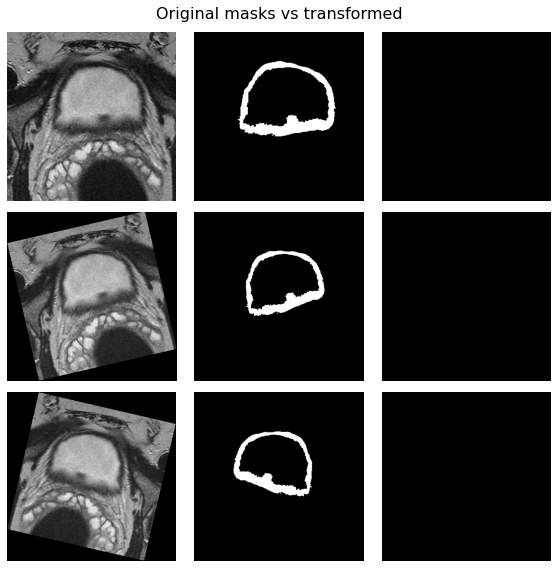

In [45]:
print('How many patients we have after augmenting the data:', len(patients))
show_augmented(15,0,1,4,patients_1,labels_wall_1,labels_tum_1)

# Resizing data
* This is a cosequence of the limited RAM given in Kaggle

In [46]:
import cv2
import numpy as np

def resize(volumes,labels_perete,labels_tumoare,shape_x,shape_y,shape_z):
    """
    Resizes our pacients to (128,128,32) because of limited RAM space
    :param volumes:(3D Numpy Array) The list of pacients that will be resized
    :param labels:(3D Numpy Array) The resized array
    """
    volume_resized=np.zeros((len(volumes),shape_x,shape_y,shape_z))
    labels_perete_resized=np.zeros((len(volumes),shape_x,shape_y,shape_z))
    labels_tumoare_resized=np.zeros((len(volumes),shape_x,shape_y,shape_z))
 
    for i in range(len(volumes)):
        for z in range(shape_z):
            img=volumes[i][:,:,z]
            img_resized = cv2.resize(img, (shape_x, shape_y), interpolation = cv2.INTER_NEAREST)

            lbl_perete=labels_perete[i][:,:,z]
            lbl_tumoare=labels_tumoare[i][:,:,z]

            lbl_perete_resized = cv2.resize(lbl_perete, (shape_x, shape_y), interpolation = cv2.INTER_NEAREST)
            lbl_tumoare_resized = cv2.resize(lbl_tumoare, (shape_x, shape_y), interpolation = cv2.INTER_NEAREST)


            volume_resized[i][:,:,z]=img_resized
            labels_perete_resized[i][:,:,z]=lbl_perete_resized
            labels_tumoare_resized[i][:,:,z]=lbl_tumoare_resized

    return volume_resized,labels_perete_resized,labels_tumoare_resized

In [47]:
patients_1, labels_wall_1, labels_tum_1 = resize(patients_1, labels_wall_1, labels_tum_1, 128, 128, 16)
patients_validare_1, labels_perete_validare_1, labels_tumori_validare_1 = resize(patients_validare_1, labels_perete_validare_1, labels_tumori_validare_1, 128, 128, 16)

In [48]:
patients_2, labels_wall_2, labels_tum_2 = resize(patients_2, labels_wall_2, labels_tum_2, 128, 128, 16)
patients_validare_2, labels_perete_validare_2, labels_tumori_validare_2 = resize(patients_validare_2, labels_perete_validare_2, labels_tumori_validare_2, 128, 128, 16)

In [49]:
patients_test, labels_wall_test, labels_tum_test = resize(patients_test, labels_wall_test, labels_tum_test, 128, 128, 16)

# Combining masks for training

In [50]:
def replace_value(data,value_replace,value):
    """
    Replaces value_replace with value in a 3D Numpy Array
    :param data: (3D Numpy array) unde se va inlocui valoarea value_replace cu value
    :param value_replace:(int)
    :param value:(int)
    :returns:
      data modificata
    """
    for i in range(len(data)):
        x=data[i]
        data[i]=np.where(x==value_replace,value, x)

    return data

In [51]:
labels_wall_1 = replace_value(labels_wall_1,1,125)
labels_tum_1 = replace_value(labels_tum_1,1,255)

labels_perete_validare_1 = replace_value(labels_perete_validare_1,1,125)
labels_tumori_validare_1 = replace_value(labels_tumori_validare_1,1,255)

In [52]:
labels_wall_2 = replace_value(labels_wall_2,1,125)
labels_tum_2 = replace_value(labels_tum_2,1,255)

labels_perete_validare_2 = replace_value(labels_perete_validare_2,1,125)
labels_tumori_validare_2 = replace_value(labels_tumori_validare_2,1,255)

In [53]:
labels_wall_test = replace_value(labels_wall_test,1,125)
labels_tum_test = replace_value(labels_tum_test,1,255)

In [54]:
def combine_labels_separate(labels_perete,labels_tumori):
    """
    Combines the masks for the wall and tumor
    """
    for i in range(len(labels_perete)):
        x=labels_perete[i]
        labels_perete[i]=np.where(x!=0, 255, x)

    for i in range(len(labels_tumori)):
        x=labels_tumori[i]
        labels_tumori[i]=np.where(x!=0, 125, x)

    labels=[]
    for i in range(len(labels_perete)):
        labels.append(labels_tumori[i]+labels_perete[i])
    
    return labels

In [55]:
# Combining the masks 
labels_1 = combine_labels_separate(labels_wall_1, labels_tum_1)
labels_validare_1 = combine_labels_separate(labels_perete_validare_1, labels_tumori_validare_1)
labels_1 = np.array(labels_1)
labels_validare_1 = np.array(labels_validare_1)

# After combining there might be overlapping regions so we will replace them with the values for tumor, because we are more interested with those
labels_1 = replace_value(labels_1,380,125)
labels_validare_1 = replace_value(labels_validare_1,380,125)

In [56]:
# Combining the masks
labels_2 = combine_labels_separate(labels_wall_2, labels_tum_2)
labels_validare_2 = combine_labels_separate(labels_perete_validare_2, labels_tumori_validare_2)
labels_2 = np.array(labels_2)
labels_validare_2 = np.array(labels_validare_2)

# After combining there might be overlapping regions so we will replace them with the values for tumor, because we are more interested with those
labels_2 = replace_value(labels_2,380,125)
labels_validare_2 = replace_value(labels_validare_2,380,125)

In [57]:
# Combining the masks
labels_test = combine_labels_separate(labels_wall_test, labels_tum_test)
labels_test = np.array(labels_test)

# After combining there might be overlapping regions so we will replace them with the values for tumor, because we are more interested with those
labels_test = replace_value(labels_test,380,125)

In [58]:
# The values need to be one-hot-encoded so they have to be in this interval [0,num_classes-1]
# We replace the values for tumor with 1 and for the wall with 2 for the encoder
def replacing_valued_for_encoding(labels):
    """
    Auxiliary function to change values
    """
    for i in range(len(labels)):
        x=labels[i]
        labels[i]=np.where(x==255, 2, x)
        labels[i]=np.where(x==125, 1, x)
    return labels

In [59]:
labels_1 = replacing_valued_for_encoding(labels_1)
labels_validare_1 = replacing_valued_for_encoding(labels_validare_1)

In [60]:
labels_2 = replacing_valued_for_encoding(labels_2)
labels_validare_2 = replacing_valued_for_encoding(labels_validare_2)

In [61]:
labels_test = replacing_valued_for_encoding(labels_test)

In [62]:
def original_and_mask(x,pacient):
    """
    Arata masca compusa 
    """
    fig, ax = plt.subplots(1,2, figsize=[12, 12])
    img_org=patients_1[pacient][:,:,x]
    img_label=labels_1[pacient][:,:,x]
    rotated_img = ndimage.rotate(img_org, 270)
    rotated_img_lb = ndimage.rotate(img_label, 270)
#     ax[0].set_title("Original")
    ax[0].imshow(rotated_img,cmap='gray')
    ax[0].axis('off')
#     ax[1].set_title("Segmentation")
    ax[1].imshow(rotated_img_lb,cmap='gray')
    ax[1].axis('off')
    plt.show()

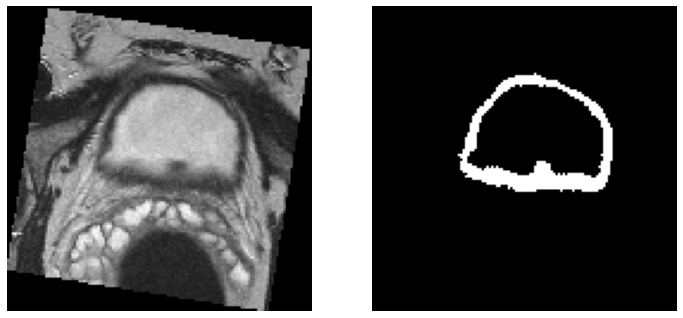

In [63]:
original_and_mask(15,2)

In [64]:
def original_and_mask_second(x,pacient):
    """
    Arata masca compusa
    """
    fig, ax = plt.subplots(1,2, figsize=[12, 12])
    img_org=patients_2[pacient][:,:,x]
    img_label=labels_2[pacient][:,:,x]
    rotated_img = ndimage.rotate(img_org, 270)
    rotated_img_lb = ndimage.rotate(img_label, 270)
#     ax[0].set_title("Original")
    ax[0].imshow(rotated_img,cmap='gray')
    ax[0].axis('off')
#     ax[1].set_title("Segmentation")
    ax[1].imshow(rotated_img_lb,cmap='gray')
    ax[1].axis('off')
    plt.show()

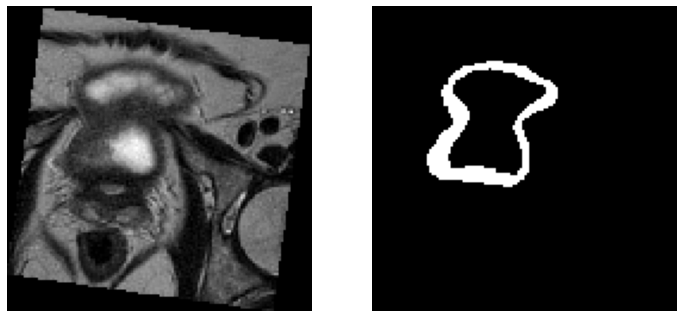

In [65]:
original_and_mask_second(14,10)

## Uniformizam valorile 

* Trebuie sa uniformizam datele pentru a ii usura treaba retelei
* Incercam sa facem ca media fiecarui data sa fie 0 si variatia sa fie 1

In [66]:
def standardize(volumes):
    """
    Vom modifica data astfel inca stdd sa fie 1 iar mean sa fie 0
    :param volumes:(Lista de 3D Numpy Arrays)
    :returns:
             standardized_image:(3D Numpy Array) versiunea standardizata a volumului
    """
    
    
    standardized_image = np.zeros(volumes.shape)

    for c in range(volumes.shape[0]):
        for z in range(volumes.shape[3]):
            
            image_slice = volumes[c,:,:,z]
            
            centered = image_slice-np.mean(image_slice)
            
         
            if np.std(centered) != 0:
                centered_scaled = np.std(centered)
               

                standardized_image[c, :, :, z] = centered / centered_scaled

    return standardized_image

In [67]:
def min_max(parent_size):
    x_max = np.amax(parent_size, axis=(0, 1, 2))
    x_min = np.amin(parent_size, axis=(0, 1, 2))
    
    x = (parent_size- x_min)/(x_max - x_min)
    return x

In [68]:
patients_1 = standardize(patients_1)
patients_validare_1 = standardize(patients_validare_1)

In [69]:
patients_2 = standardize(patients_2)
patients_validare_2 = standardize(patients_validare_2)

In [70]:
patients_test = standardize(patients_test)

# Last steps of preprocessing

In [71]:
# ---obligatory---
# Extindem dimensiunea listei de pacienti pentru a fi introdusa in model
patients_1 = np.expand_dims(patients_1,-1)
patients_validare_1 = np.expand_dims(patients_validare_1,-1)

In [72]:
patients_2 = np.expand_dims(patients_2,-1)
patients_validare_2 = np.expand_dims(patients_validare_2,-1)

In [73]:
patients_test = np.expand_dims(patients_test,-1)

In [74]:
# def shuffle_data(X,Y):
#     """
#     :param X:(list of 3D Numpy Arrays) lista cu datele pacientilor
#     :param Y:(list of 3D Numpy Arrays) lista cu masti(tumoare+perete) pacientilor
#     :returns: Mostre impartite in : data pentru antrenare, si data pentru testare
#     """
#     indexes=[i for i in range(X.shape[0])]
#     trainSample=np.random.choice(indexes,int(len(indexes)),replace=False)
  
#     x_train=[X[i] for i in trainSample]
#     y_train=[Y[i] for i in trainSample]
    
#     x_norm=[X_norm[i] for i in trainSample]
#     return x_train,y_train,x_norm


# x_train,y_train=split_data(patients,normalize_patients,labels)
# x_valid,y_valid=split_data(patients_validare,normalize_patients_validare,labels_validare)

# # x_train,y_train=split_data(patients_copy,labels_copy)
# # x_test,y_test=split_data(patients_validare_copy,labels_validare_copy)

# # # Data de antrenare are 80% din mostre pe cand data de testare are 20%
# print('Cate samples de antrenare avem')
# print(len(x_train))
# print('Cate samples de antrenare avem')
# print(len(x_test))

In [75]:
x_first_batch = patients_1
y_first_batch = labels_1

x_valid_first_batch = patients_validare_1
y_valid_first_batch = labels_validare_1

In [76]:
x_second_batch = patients_2
y_second_batch = labels_2

x_valid_second_batch = patients_validare_2
y_valid_second_batch = labels_validare_2

In [77]:
x_test = patients_test
y_test = labels_test

In [78]:
x_first_batch = np.array(x_first_batch)
y_first_batch = np.array(y_first_batch)

x_valid_first_batch = np.array(x_valid_first_batch)
y_valid_first_batch = np.array(y_valid_first_batch)

In [79]:
x_second_batch = np.array(x_second_batch)
y_second_batch = np.array(y_second_batch)
 
x_valid_second_batch = np.array(x_valid_second_batch)
y_valid_second_batch = np.array(y_valid_second_batch)

In [80]:
x_test = np.array(x_test)
y_test = np.array(y_test)

In [81]:
y_first_batch = utils.to_categorical(y_first_batch,3)
y_valid_first_batch = utils.to_categorical(y_valid_first_batch,3)

In [82]:
y_second_batch = utils.to_categorical(y_second_batch,3)
y_valid_second_batch = utils.to_categorical(y_valid_second_batch,3)

In [83]:
y_test = utils.to_categorical(y_test,3)

In [84]:
print(x_first_batch.shape)
print(y_first_batch.shape)

print(x_valid_second_batch.shape)
print(y_valid_second_batch.shape)

(42, 128, 128, 16, 1)
(42, 128, 128, 16, 3)
(7, 128, 128, 16, 1)
(7, 128, 128, 16, 3)


In [85]:
print(x_second_batch.shape)
print(y_second_batch.shape)

print(x_valid_second_batch.shape)
print(y_valid_second_batch.shape)

(42, 128, 128, 16, 1)
(42, 128, 128, 16, 3)
(7, 128, 128, 16, 1)
(7, 128, 128, 16, 3)


In [86]:
print(x_test.shape)
print(y_test.shape)

(5, 128, 128, 16, 1)
(5, 128, 128, 16, 3)


In [87]:
del patients_1
del labels_1
del patients_validare_1
del labels_validare_1

In [88]:
del patients_2
del labels_2
del patients_validare_2
del labels_validare_2

In [89]:
from numpy import savez_compressed

In [90]:
savez_compressed('x_first_batch.npz', x_first_batch)
savez_compressed('y_first_batch.npz', y_first_batch)

In [91]:
savez_compressed('x_second_batch.npz', x_second_batch)
savez_compressed('y_second_batch.npz', y_second_batch)

In [92]:
savez_compressed('x_valid_first_batch.npz', x_valid_first_batch)
savez_compressed('y_valid_first_batch.npz', y_valid_first_batch)

In [93]:
savez_compressed('x_valid_second_batch.npz', x_valid_second_batch)
savez_compressed('y_valid_second_batch.npz', y_valid_second_batch)

In [94]:
savez_compressed('x_test.npz', x_test)
savez_compressed('y_test.npz', y_test)